In [70]:
import time
start = time.time()

from models import *
from utils import *

## Training & Testing Subjects

In [71]:
Str = pd.read_csv(f'data/human_activity/UCI HAR Dataset/train/subject_train.txt', header=None, sep=' ', skipinitialspace=True)
Sts = pd.read_csv(f'data/human_activity/UCI HAR Dataset/test/subject_test.txt', header=None, sep=' ', skipinitialspace=True)

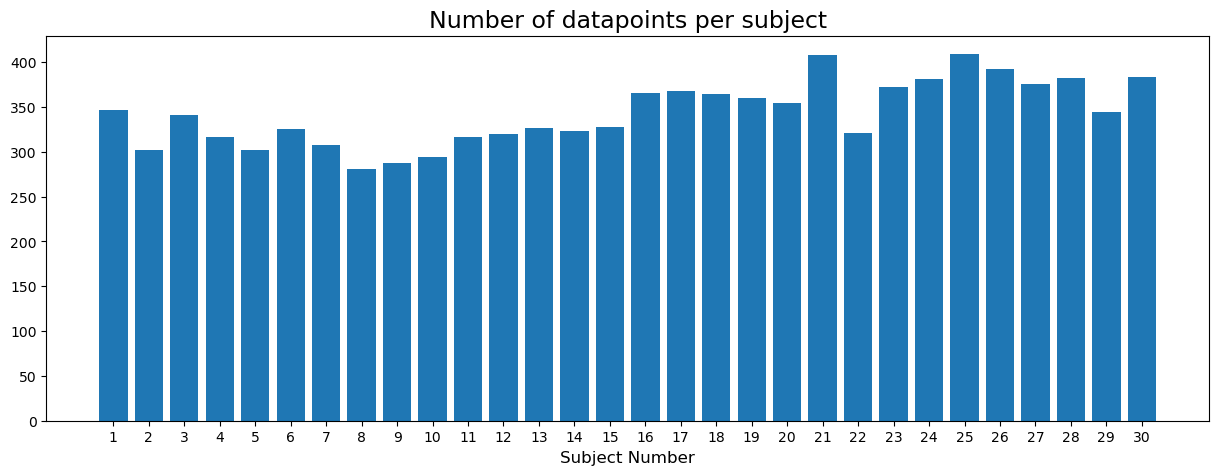

In [72]:
subj_count = pd.concat((Str, Sts), axis=0).groupby(by=0)[Str.columns].count().rename(columns={0: 'Count'}).rename_axis(columns='Subject', index=None)
plt.figure(figsize=(15,5))
plt.bar(subj_count.index, subj_count['Count'])
plt.title('Number of datapoints per subject', fontsize=17)
plt.xlabel('Subject Number', fontsize=12)
plt.xticks(ticks=subj_count.index)
plt.show()

In [73]:
print('Subjects used as training data')
print(np.unique(Str))

Subjects used as training data
[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [74]:
print('Subjects used as testing data')
print(np.unique(Sts))

Subjects used as testing data
[ 2  4  9 10 12 13 18 20 24]


## Import RAW functional data
### This is the 128 sampling windows data. Each row overlaps 50% with the previous row

In [75]:
label_train = (pd.read_csv
               (f'data/human_activity/UCI HAR Dataset/train/y_train.txt', header=None, sep=' ', skipinitialspace=True))
label_test = (pd.read_csv
              (f'data/human_activity/UCI HAR Dataset/test/y_test.txt', header=None, sep=' ', skipinitialspace=True))


In [76]:
axes = ['x', 'y', 'z']
sets = ['train', 'test']
for i in sets:

    globals()[f'body_acc_{i}'] = []
    globals()[f'body_gyro_{i}'] = []
    globals()[f'tot_acc_{i}'] = []

    for j in axes:

        acc = pd.read_csv(f'data/human_activity/UCI HAR Dataset/{i}/Inertial Signals/body_acc_{j}_{i}.txt', header=None, sep=' ', skipinitialspace=True)
        gyro = pd.read_csv(f'data/human_activity/UCI HAR Dataset/{i}/Inertial Signals/body_gyro_{j}_{i}.txt', header=None, sep=' ', skipinitialspace=True)
        tot = pd.read_csv(f'data/human_activity/UCI HAR Dataset/{i}/Inertial Signals/total_acc_{j}_{i}.txt', header=None, sep=' ', skipinitialspace=True)

        globals()[f'body_acc_{j}_{i}'] = acc
        globals()[f'body_gyro_{j}_{i}'] = gyro
        globals()[f'tot_acc_{j}_{i}'] = tot

        globals()[f'body_acc_{i}'].append(acc)
        globals()[f'body_gyro_{i}'].append(gyro)
        globals()[f'tot_acc_{i}'].append(tot)

    globals()[f'body_acc_{i}'] = np.stack(globals()[f'body_acc_{i}'], axis=2)
    globals()[f'body_gyro_{i}'] = np.stack(globals()[f'body_gyro_{i}'], axis=2)
    globals()[f'tot_acc_{i}'] = np.stack(globals()[f'tot_acc_{i}'], axis=2)


In [77]:
labl = {1: 'Walking', 2: 'Walk Upstairs', 3: 'Walk Downstairs', 4: 'Sitting', 5: 'Standing', 6: 'Laying'}
print('Number of datapoints per class')
pd.concat((label_train, label_test), axis=0).groupby(by=0)[Str.columns].count().rename(columns={0: 'Count'}).rename_axis(columns='Class', index=None).rename(index=labl)

Number of datapoints per class


Class,Count
Walking,1722
Walk Upstairs,1544
Walk Downstairs,1406
Sitting,1777
Standing,1906
Laying,1944


Slight imbalances between classes, but not too bad.

## Re-constructing Raw Signals (i.e., undo overlapping signals)

I hid most of the code in utils.py


In [78]:
sensors = ['ba', 'gyr', 'tot']
subjects = {0: pd.Series(Str.iloc[:, 0]), 1: pd.Series(Sts.iloc[:, 0])}
sets = ['train', 'test']
RAW_train = raw_data_construct_Explore('train', subjects[0], globals())
RAW_test = raw_data_construct_Explore('test', subjects[1], globals())

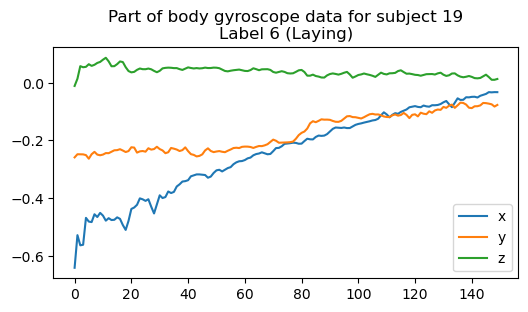

In [79]:
subj = 19 # training subject no.
l = 6 # labels (1-6)

plt.figure(figsize=(6, 3))
plt.plot(RAW_train[f'Raw_gyr_XYZ_subj{subj}_{l}_train'][0:150], label=axes)
plt.title(f'Part of body gyroscope data for subject {subj}\nLabel {l} ({labl[l]})')
plt.legend()
plt.show()

### Splitting data into training and testing, and concatenating them to be ready for the SVM model (code hidden in utils.py)

In [80]:
Data_raw, Label_raw = raw_data_construct_ML(globals())

### I stored the reconstructed raw data in 3-dimensional arrays (tensor). I will unfold them so that we end up with 2-dimensional arrays that can be used for training and testing

In [81]:
X_data = np.concatenate((Data_raw['X_raw_train'],
                         Data_raw['X_raw_test']), axis=0)

y_train = Label_raw['y_raw_train'].astype(int)
y_test = Label_raw['y_raw_test'].astype(int)

i_train = range(len(y_train))
i_test = range(len(y_train), len(y_train) + len(y_test))

X_train = np.reshape(X_data[i_train].T, (-1, X_data[i_train].shape[0])).T
X_test = np.reshape(X_data[i_test].T, (-1, X_data[i_test].shape[0])).T

### Ensuring X unfolded the way we expect, i.e., move every 2D matrix along axis=2, concatenate its beginning with the end of the previous 2D matrix. The number of rows remains the same, only the columns increase by 64 each time

In [82]:
print(np.array_equal(X_train[:100, 64:128], Data_raw['X_raw_train'][:100, :, 1]))
print(np.array_equiv(X_train[:100, 64:128], Data_raw['X_raw_train'][:100, :, 1]))
print(np.allclose(X_train[:100, 64:128], Data_raw['X_raw_train'][:100, :, 1]))

True
True
True


In [83]:
print(np.array_equal(X_test[:100, 64:128], Data_raw['X_raw_test'][:100, :, 1]))
print(np.array_equiv(X_test[:100, 64:128], Data_raw['X_raw_test'][:100, :, 1]))
print(np.allclose(X_test[:100, 64:128], Data_raw['X_raw_test'][:100, :, 1]))

True
True
True


### Plotting the raw data

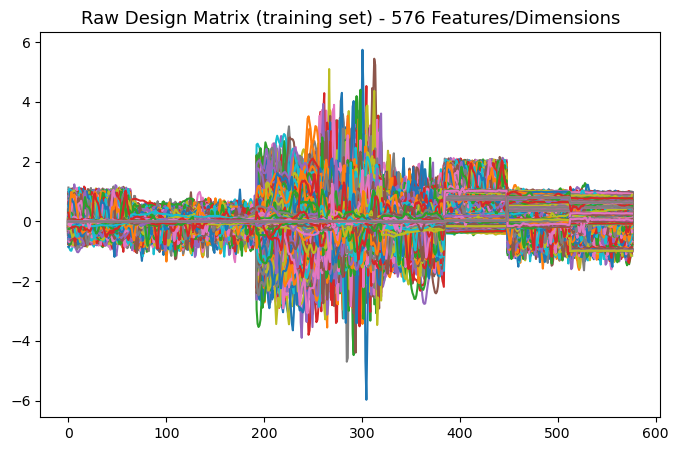

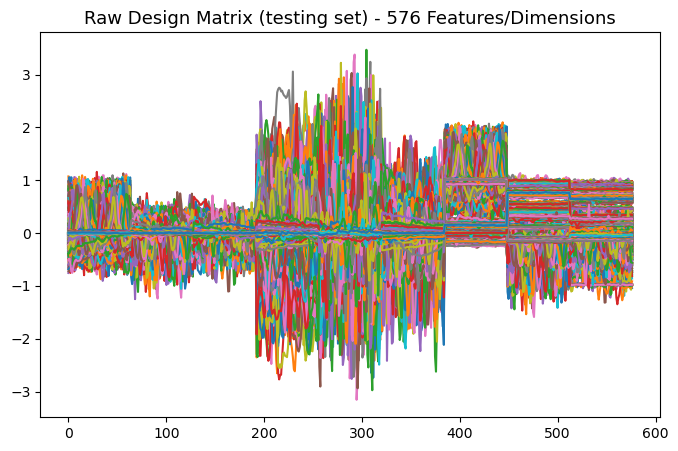

In [84]:
for i in sets:
    x = np.linspace(0, globals()[f'X_{i}'].shape[1], globals()[f'X_{i}'].shape[1])
    plt.figure(figsize=(8, 5) ,dpi=100)
    plt.plot(x, globals()[f'X_{i}'].T)
    plt.title(f'Raw Design Matrix ({i}ing set) - {globals()[f"X_{i}"].shape[1]} Features/Dimensions', fontsize=13)
    #plt.savefig('Concatenated raw signals.svg')
    plt.show()

# RAW DATA
This will be our baseline model

# 1. Modeling using RAW signal data

### The model will be trained on the raw data

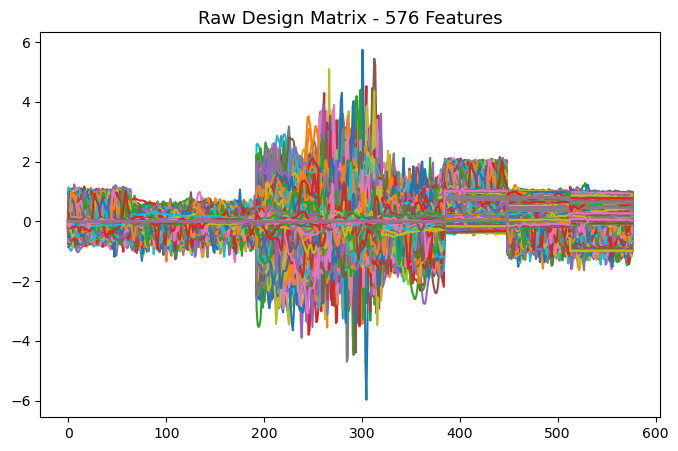

In [119]:
x = np.linspace(0, X_train.shape[1], X_train.shape[1])
plt.figure(figsize=(8, 5) ,dpi=100)
plt.plot(x, X_train.T)
plt.title(f'Raw Design Matrix - {X_train.shape[1]} Features', fontsize=13)
#plt.savefig('Concatenated_raw_matrix.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### Using SVM: varying C from 0.2 to 200, with 20 steps and pick highest F1-score:

In [86]:
X_tr_raw = X_train
X_ts_raw = X_test

C_raw, score_raw, conf_raw = svm_model(X_tr_raw, X_ts_raw, y_train, y_test, C_start=0.2, C_stop=200, step=20, cv=5)

C=0.2, Cross-Validation F1-macro: 89.13%, Test F1-macro: 83.31%
	CV scores: [87.94 90.05 89.61 88.33 89.73]

C=10.72, Cross-Validation F1-macro: 94.52%, Test F1-macro: 89.50%
	CV scores: [93.89 94.97 94.8  94.83 94.12]

C=21.23, Cross-Validation F1-macro: 94.47%, Test F1-macro: 89.70%
	CV scores: [93.77 95.03 94.92 94.59 94.05]

C=31.75, Cross-Validation F1-macro: 94.47%, Test F1-macro: 89.95%
	CV scores: [93.83 94.85 95.04 94.58 94.05]

C=42.26, Cross-Validation F1-macro: 94.48%, Test F1-macro: 90.01%
	CV scores: [93.89 94.85 95.04 94.46 94.18]

C=52.78, Cross-Validation F1-macro: 94.44%, Test F1-macro: 89.98%
	CV scores: [93.82 94.91 95.04 94.39 94.05]

C=63.29, Cross-Validation F1-macro: 94.47%, Test F1-macro: 90.04%
	CV scores: [93.76 95.22 94.8  94.52 94.05]

C=73.81, Cross-Validation F1-macro: 94.51%, Test F1-macro: 90.00%
	CV scores: [93.82 95.09 94.8  94.64 94.18]

C=84.33, Cross-Validation F1-macro: 94.53%, Test F1-macro: 89.94%
	CV scores: [93.82 95.09 94.74 94.7  94.3 ]

C=9

# B-SPLINES

### Function to construct b-spline basis matrix

In [87]:
from scipy.interpolate import BSpline
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

### Function to obtain reduced (downscaled) data
#### This function is fed the data, number of knots, and degree of b-splines, it gives back the lower dimensional data and basis matrix I will use 35 knots, i.e., reduce the dimension of the data from 576 to 37 (35 knots + 2 to control the edges)

In [88]:
def BS(data, knots, degree=3):
    x = np.linspace(0, 1, data.shape[1])
    knots1 = np.linspace(0, 1, knots) #knots per sensor
    B = BSplineBasis(x, knots1, degree=degree)[:, :-2]
    return np.linalg.lstsq(B, data.T)[0].T, B

### Obtaining the reduced matrices for training and testing sets

In [89]:
def BS_long(data, knots, degree=3):
    X_reduced = []
    x = np.linspace(0, 1, data.shape[1])
    knots1 = np.linspace(0, 1, knots) #knots per sensor
    B = BSplineBasis(x, knots1, degree=degree)[:, :-2]

    for i in range(data.shape[2]):
        B_coefs = np.linalg.lstsq(B, data[:,:,i].T)[0].T
        X_reduced.append(B_coefs)

    X_reduced = np.stack(X_reduced, axis=2)
    X_reduced_concat = np.reshape(X_reduced.T, (-1, X_reduced.shape[0])).T

    return X_reduced_concat, X_reduced, B

### Obtaining the smooth data by multiplying the coefs by the basis matrix

In [90]:
knots = 5
X_reduced_concat, X_reduced, B1 = BS_long(X_data, knots=knots, degree=3)

In [91]:
X_data_smooth = np.einsum('ijk,lj->ilk', X_reduced, B1, optimize = True)


### Generating plots.

#### I randomized the selection of the datapoints, if you re-run the cell you will get plots of different datapoints

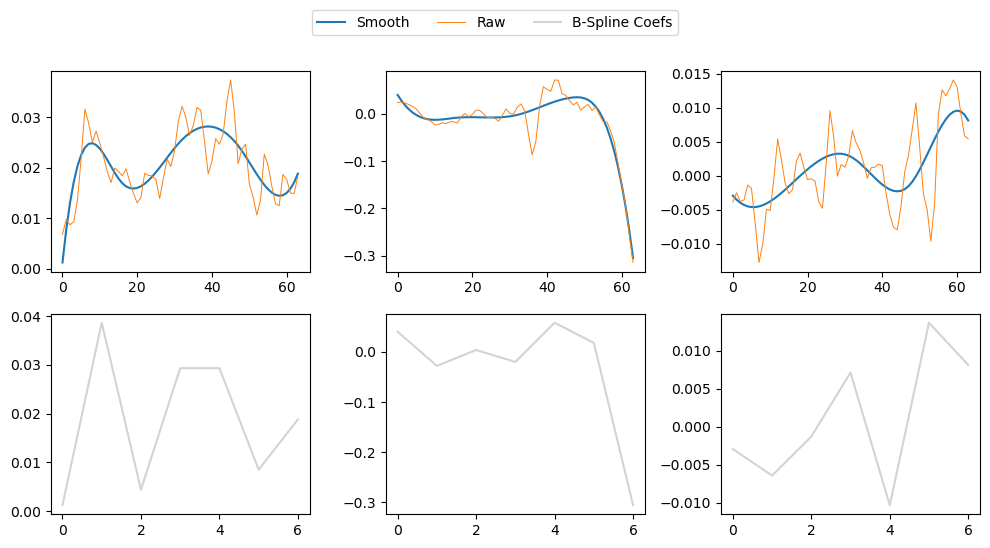

In [92]:

# generage indices of random rows (signals) to plot
rand_signals = [np.random.randint(0, X_data_smooth.shape[0]) for i in range(3)]
rand_sensor = np.random.randint(0, X_data_smooth.shape[2])

# plot the signal
fig, ax = plt.subplots(2, 3, figsize=(10, 5))

for i, signal in enumerate(rand_signals):
    ax[0, i].plot(X_data_smooth[signal, :, rand_sensor], label='Smooth')
    ax[0, i].plot(X_data[signal, :, rand_sensor], label='Raw', linewidth=0.7)
    ax[1, i].plot(X_reduced[signal, :, rand_sensor], label='B-Spline Coefs', color='lightgray')

handles, labels = [], []
for a in ax.flatten():
    for h, l in zip(*a.get_legend_handles_labels()):
        if l not in labels:  # Avoid duplicates
            handles.append(h)
            labels.append(l)

fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
#plt.savefig(f'B-spline_rand_sample.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


Notice how the smooth curve cuts through most of the noise and follows more or less the trend of the data.

We can also see how the raw data and the lower dimensional data we obtained using b-splines have a similar structure, despite the much lower dimension, in this case I chose a window of 182 in the raw data, which translates to roughly 12 knots in the b-splines coefficients.

**Note: the higher the number of knots, the closer the structure of the reduced signal to the original signal**

### Let's manually obtain B-spline coefs, and then examine its sturcture compared to the original data matrix

### The least squares solution is:

$ B_{coefs} = (B_s.B_s^{\top})^{-1} B_s X_{raw} $

$X_{raw}$ is our data

$B_s$ is the B-spline basis

$(B_s.B_s^{\top})^{-1} B_s$ is moore-penrose psuedo inverse of the $B_s$. Will refer to it in the code below as `B1_inv`

$B_{coefs}$ is the lower dimensional representation of our data

In [93]:
B1_inv = np.linalg.pinv(B1)

One of the reasons why b-splines are useful, is that their design ensures that the columns of the lower dimensional matrix represent the weighted average of the columns in the raw data. When we examin the sum across $B_s$ rows, we'll see that they are all equal to 1, this property is called **Partition of Unity**, which helps in preserving the original data.

In [94]:
B1.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

If we plot the basis matrix, we can visually confirm that the values add up to 1 at each vertical slice.

Take for example `x = 10` in the plot of be basis matrix below. The red and blue lines intersect roughly at `0.045`, so they both add up to `0.09`. The green line is roughly at `0.37`, and the orange line is roughly at `0.54` If we add them all together we get 1, and so on.

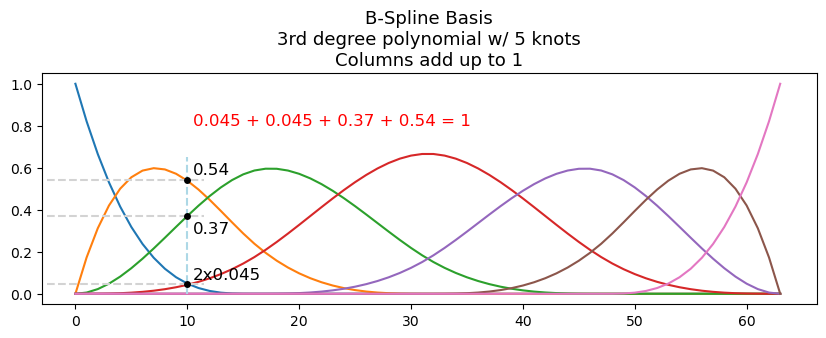

In [95]:
BS_partition_unity(globals(), save_plot=False)

This is maintained for `B1_inv`, but this time the number of rows is only 7.

In [96]:
B1_inv.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

To obtain $B_{coefs}$, we multiply `B1_inv` by $X_{raw}$. The coefficients represent the **weighted average** of the columns of the raw data, which means that the average of the raw data must be close to the average of the reduced data. As you can see below


In [97]:
B_coef = (B1_inv @ X_data.T).T

In [98]:
B_coef.mean()

0.10152364608311713

In [99]:
X_data.mean()

0.10115460501800164

The mean of the reduced data (B-spline Coefficients) is close to the mean of the raw data. Of course, the more knots we have in the reduced data, the closer the means are. **This, along with examining the plots above, shows that the coefficients, despite having a much lower dimension, preserve both temporal and numerical structures of the raw data.**

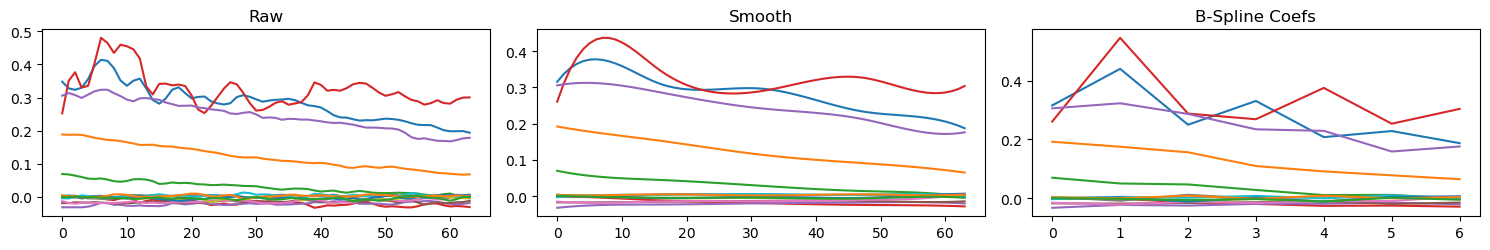

In [100]:
label = 6 #np.random.randint(1, 7)
labels = ['Raw', 'Smooth', 'B-Spline Coefs']
D_raw = X_data[np.where(y_train == label)[0], :, 5][:15].T
D_smooth = X_data_smooth[np.where(y_train == label)[0], :, 5][:15].T
D_coefs = B_coef[np.where(y_train == label)[0], :,  5][:15].T

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for i, data in enumerate((D_raw, D_smooth, D_coefs)):
    ax[i].plot(data)
    ax[i].set_title(labels[i])

#fig.text(0.5, 0.02, f'Data for y-axis body accelerometer, label = {label}', ha='center', va='center', fontsize=12)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()

# 2. Modeling using B-spline Coefs (REDUCED data)

### The model will be trained on the reduced data.

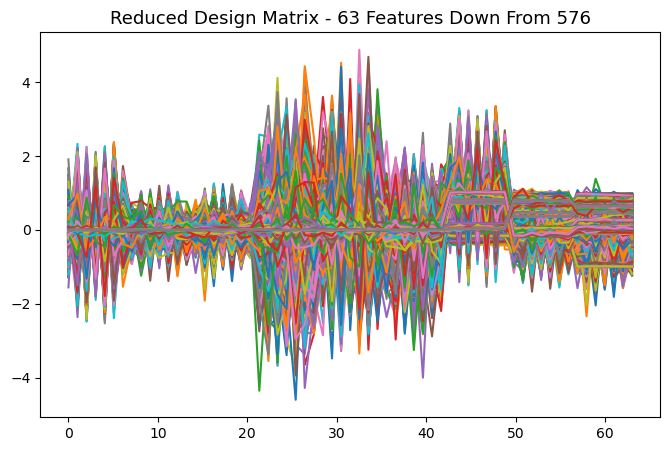

In [101]:
x = np.linspace(0, X_reduced_concat[i_train].shape[1], X_reduced_concat[i_train].shape[1])
plt.figure(figsize=(8, 5) ,dpi=100)
plt.plot(x, X_reduced_concat[i_train].T)
plt.title(f'Reduced Design Matrix - {X_reduced_concat[i_train].shape[1]} Features Down From {X_train.shape[1]}', fontsize=13)
#plt.savefig(f'Reduced_matrix.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### Using SVM: varying C from 0.2 to 200, with 20 steps and pick highest F1-score:

In [102]:
X_reduced_concat, _, B1 = BS_long(X_data, knots=5, degree=3)

X_tr_bs = X_reduced_concat[i_train]
X_ts_bs = X_reduced_concat[i_test]

C_bs, score_bs, conf_bs = (
svm_model(X_tr_bs, X_ts_bs, y_train, y_test, C_start=0.2, C_stop=200, step=10, cv=5))

C=0.2, Cross-Validation F1-macro: 91.51%, Test F1-macro: 88.53%
	CV scores: [90.47 92.26 92.07 90.9  91.85]

C=22.4, Cross-Validation F1-macro: 94.75%, Test F1-macro: 90.70%
	CV scores: [94.17 94.82 95.19 94.94 94.6 ]

C=44.6, Cross-Validation F1-macro: 94.70%, Test F1-macro: 90.76%
	CV scores: [94.11 94.95 95.32 94.69 94.42]

C=66.8, Cross-Validation F1-macro: 94.72%, Test F1-macro: 90.82%
	CV scores: [94.3  94.94 95.38 94.63 94.35]

C=89.0, Cross-Validation F1-macro: 94.72%, Test F1-macro: 90.92%
	CV scores: [94.24 94.88 95.44 94.56 94.47]

C=111.2, Cross-Validation F1-macro: 94.74%, Test F1-macro: 90.98%
	CV scores: [94.05 94.88 95.5  94.69 94.6 ]

C=133.4, Cross-Validation F1-macro: 94.76%, Test F1-macro: 91.02%
	CV scores: [94.11 94.88 95.44 94.69 94.66]

C=155.6, Cross-Validation F1-macro: 94.74%, Test F1-macro: 90.95%
	CV scores: [94.11 94.76 95.38 94.75 94.72]

C=177.8, Cross-Validation F1-macro: 94.73%, Test F1-macro: 90.98%
	CV scores: [94.11 94.76 95.38 94.75 94.66]

C=200.0

# 3. Modeling using B-spline Coefs (REDUCED data) - multiple resolutions

I will concatenate multiple reduced data rather than just one, each with a different number of knots in order to capture different kinds of hidden trends in the data.

In [103]:
X_high, _, B_high = BS_long(X_data, knots=5, degree=3)
X_mid, _, B_mid = BS_long(X_data, knots=4, degree=3)
X_low, _, B_low = BS_long(X_data, knots=3, degree=3)
X_lower, _, B_lower = BS_long(X_data, knots=2, degree=3)

X_tr_bs_mult = np.concatenate((X_high, X_mid, X_low, X_lower), axis=1)[i_train]
X_ts_bs_mult = np.concatenate((X_high, X_mid, X_low, X_lower), axis=1)[i_test]

### The model will be trained on the reduced data.

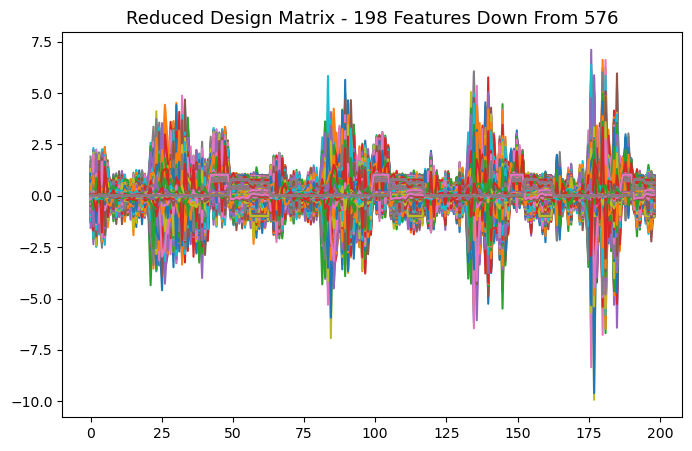

In [104]:
x = np.linspace(0, X_tr_bs_mult.shape[1], X_tr_bs_mult.shape[1])
plt.figure(figsize=(8, 5) ,dpi=100)
plt.plot(x, X_tr_bs_mult.T)
plt.title(f'Reduced Design Matrix - {X_tr_bs_mult.shape[1]} Features Down From {X_train.shape[1]}', fontsize=13)
#plt.savefig('Concatenated B-spline.svg')
plt.show()

### Using SVM: varying C from 0.2 to 200, with 20 steps and pick highest F1-score:

smooth using 80 coef, then obtain lower coefs of smoothed. use low and high with 30 and 50 coefs concatenated

In [105]:
C_bs_mult, score_bs_mult, conf_bs_mult = (
svm_model(X_tr_bs_mult, X_ts_bs_mult, y_train, y_test, C_start=0.2, C_stop=100, step=20, cv=5))

C=0.2, Cross-Validation F1-macro: 92.53%, Test F1-macro: 90.65%
	CV scores: [92.02 93.26 92.9  92.01 92.47]

C=5.45, Cross-Validation F1-macro: 95.06%, Test F1-macro: 91.54%
	CV scores: [94.54 95.25 95.63 95.05 94.84]

C=10.71, Cross-Validation F1-macro: 95.07%, Test F1-macro: 91.37%
	CV scores: [94.61 95.19 95.5  95.18 94.9 ]

C=15.96, Cross-Validation F1-macro: 95.10%, Test F1-macro: 91.50%
	CV scores: [94.54 95.13 95.5  95.24 95.09]

C=21.21, Cross-Validation F1-macro: 95.09%, Test F1-macro: 91.47%
	CV scores: [94.42 95.13 95.63 95.17 95.09]

C=26.46, Cross-Validation F1-macro: 95.10%, Test F1-macro: 91.50%
	CV scores: [94.61 95.19 95.69 95.05 94.96]

C=31.72, Cross-Validation F1-macro: 95.11%, Test F1-macro: 91.59%
	CV scores: [94.74 95.25 95.56 95.05 94.96]

C=36.97, Cross-Validation F1-macro: 95.14%, Test F1-macro: 91.75%
	CV scores: [94.74 95.25 95.69 94.99 95.02]

C=42.22, Cross-Validation F1-macro: 95.14%, Test F1-macro: 91.75%
	CV scores: [94.74 95.38 95.63 94.93 95.02]

C=47

# FPCA

# 4. Modeling using Functional PCA (FPCA)


In [106]:
X_pca_tr = X_train.copy()
X_pca_ts = X_test.copy()

### Centering the training set and obtaining the covariance matrix

In [107]:
mean_tr = X_pca_tr.mean(0)
diffs_tr = X_pca_tr - mean_tr
Cov = np.cov(diffs_tr.T)

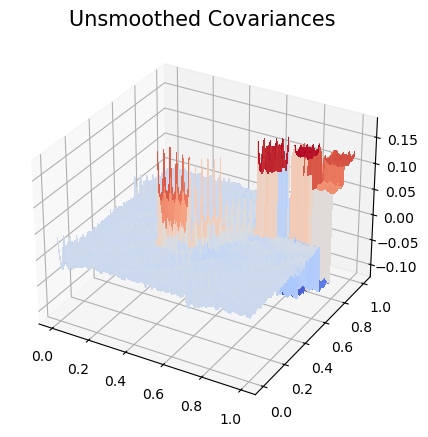

In [108]:
x = np.linspace(0, 1, Cov.shape[0])
grids = np.meshgrid(x, x)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(grids[0], grids[1], Cov, cmap='coolwarm',
                linewidth=0, antialiased=False)
plt.title('Unsmoothed Covariances', fontsize=15)
#plt.savefig('Unsmoothed_Covariances.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### I will run the gaussian filter throught the matrix and then I'll obtain the eigenvectors.

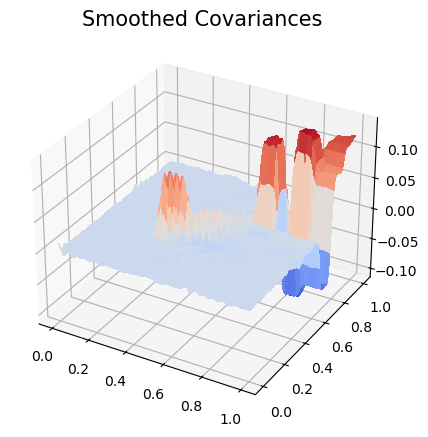

In [109]:
from scipy.ndimage import gaussian_filter

Cov_s = gaussian_filter(Cov, sigma=7)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(grids[0], grids[1], Cov_s, cmap='coolwarm',
                linewidth=0, antialiased=False)
plt.title('Smoothed Covariances', fontsize=15)
#plt.savefig('Smoothed_Covariances.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### Obtaining Eigenvectors of the smoothed covariance matrix

In [110]:
l, psi = np.linalg.eigh(Cov_s) #l = eigenvalues, psi = eigenvectors

### Explained Variance

In [111]:
# manually calculating Cumulative explained variance
cum_var = []
ggg = l / np.sum(l)
temp = 0
for i in range(1,len(ggg)+1):
    temp += ggg[-i]
    cum_var.append(temp)
n_pc = 30    
print(f'Cumulative explained variance for the first {n_pc} PCs')
cum_var = pd.DataFrame(cum_var.copy())
cum_var.index = range(1, len(cum_var)+1)
cum_var.iloc[:n_pc].rename(columns={0: 'Explained Variance'}).rename_axis(columns='PC', index=None)


Cumulative explained variance for the first 30 PCs


PC,Explained Variance
1,0.553768
2,0.670309
3,0.749862
4,0.805362
5,0.856015
6,0.889897
7,0.911752
8,0.930710
9,0.940899
10,0.949331


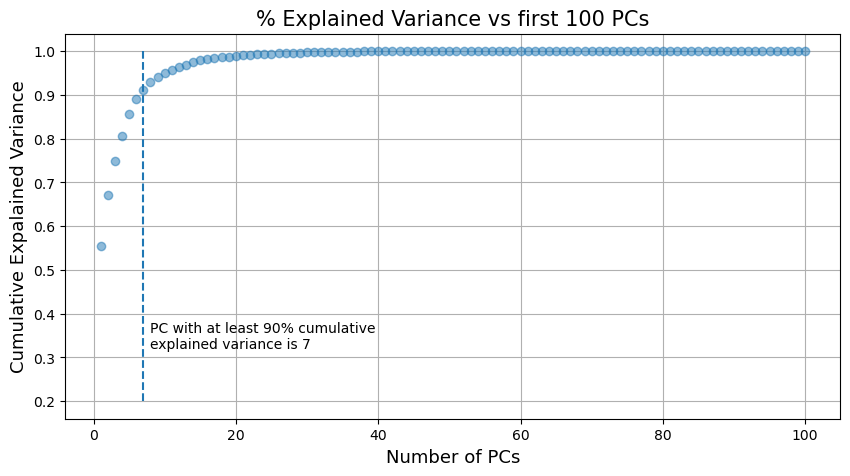

In [112]:
pcs = 100
x2 = range(1, pcs+1)
p = x2[np.where(np.array(cum_var) >= 0.9)[0][0]]
plt.figure(figsize=(10, 5) ,dpi=100)
plt.plot(x2, cum_var.iloc[:pcs][0], 'o', label='Cumulative Expalined Variance', alpha=0.5)
plt.vlines(p, ymin=0.2, ymax=1, linestyles='dashed')
plt.text(p+1, 0.32, f'PC with at least 90% cumulative \nexplained variance is {p}')
plt.title('% Explained Variance vs first 100 PCs', fontsize=15)
plt.xlabel('Number of PCs', fontsize=13)
plt.ylabel('Cumulative Expalained Variance', fontsize=13)

#plt.xticks(np.arange(0, 101, 10))

plt.grid()
plt.savefig('Explained variance.png'
            '', bbox_inches='tight', pad_inches=0.1)
plt.show()

From the plot above, we can see that the first 7 PCs contain `90%` or more of the variability in the data, i.e., it is sufficient to use only 11 features to represent `90%` of the information contained in the data.

Now I will use the eigenvectors obtained from the covariance matrix of the training data to project the training and testing data, and I will fit the SVM model to the projected data.

### I will only test the first 40 PCs, since beyond the 20th PC, the explained variance gets very close to `100%`
### Using SVM: varying C from 5 to 30, with 5 steps, adding 1 PC at a time and pick highest F1-score:

In [113]:
PC_raw_pca, score_raw_pca, C_raw_pca, conf_raw_pca = (
pca_svm(X_pca_tr, X_pca_ts, y_train, y_test, C_start=5,
        C_stop=30, step=5, pc_start=45, pc_stop=60, cv=5, gauss_sigm=7))

PC=45, C=17.5, Cross-Validation F1-macro = 95.00%, Test F1-macro = 89.93%, 
	CV scores: [94.32 95.51 95.04 95.11 95.03]

PC=46, C=17.5, Cross-Validation F1-macro = 94.91%, Test F1-macro = 90.04%, 
	CV scores: [94.24 95.39 94.89 95.11 94.9 ]

PC=47, C=17.5, Cross-Validation F1-macro = 94.93%, Test F1-macro = 90.04%, 
	CV scores: [94.32 95.45 94.81 95.11 94.98]

PC=48, C=17.5, Cross-Validation F1-macro = 94.90%, Test F1-macro = 90.28%, 
	CV scores: [94.23 95.39 94.75 95.19 94.97]

PC=49, C=17.5, Cross-Validation F1-macro = 94.89%, Test F1-macro = 90.17%, 
	CV scores: [94.3  95.45 94.68 95.11 94.88]

PC=50, C=17.5, Cross-Validation F1-macro = 94.89%, Test F1-macro = 90.27%, 
	CV scores: [94.24 95.45 94.62 95.19 94.94]

PC=51, C=11.25, Cross-Validation F1-macro = 94.88%, Test F1-macro = 90.23%, 
	CV scores: [94.23 95.45 94.62 95.19 94.9 ]

PC=52, C=11.25, Cross-Validation F1-macro = 94.85%, Test F1-macro = 90.23%, 
	CV scores: [94.16 95.39 94.56 95.19 94.96]

PC=53, C=17.5, Cross-Validatio

## Results:

In [114]:
from tabulate import tabulate

dim_r = X_train.shape[1]
dim_bs = X_tr_bs.shape[1]
dim_bs_mult = X_tr_bs_mult.shape[1]
dim_pc = PC_raw_pca

table =         [['Modeling Technique', 'No. of\nFeatures', 'Reduction in\nFeatures', 'Test\nF1-score'],
                 ['Raw Data', dim_r, f'None', f'{score_raw * 100:.2f}%'],
                 ['B-spline', dim_bs, f'{dim_r / dim_bs:.2f}x', f'{score_bs * 100:.2f}%'],
    ['B-spline Multi-resolution', dim_bs_mult, f'{dim_r / dim_bs_mult:.2f}x', f'{score_bs_mult * 100:.2f}%'],
                 ['FPCA', dim_pc, f'{dim_r / dim_pc:.2f}x', f'{score_raw_pca * 100:.2f}%']]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════════════╤════════════╤════════════════╤════════════╕
│ Modeling Technique        │     No. of │ Reduction in   │ Test       │
│                           │   Features │ Features       │ F1-score   │
╞═══════════════════════════╪════════════╪════════════════╪════════════╡
│ Raw Data                  │        576 │ None           │ 90.04%     │
├───────────────────────────┼────────────┼────────────────┼────────────┤
│ B-spline                  │         63 │ 9.14x          │ 91.02%     │
├───────────────────────────┼────────────┼────────────────┼────────────┤
│ B-spline Multi-resolution │        198 │ 2.91x          │ 91.97%     │
├───────────────────────────┼────────────┼────────────────┼────────────┤
│ FPCA                      │         54 │ 10.67x         │ 90.30%     │
╘═══════════════════════════╧════════════╧════════════════╧════════════╛


In [116]:
end = time.time()

In [117]:
mod = np.mod(end - start, 60)
print(f'Notebook elapsed time: {(end - start - mod)/60:.0f} minute(s), {mod:.2f} second(s)')

Notebook elapsed time: 7 minute(s), 21.90 second(s)
